# Statistical models

In the notebook `01_Data_Exploration` we have identified a trend of increasing sales over the years as well as seasonality within both years and weeks.

To predict the next three month of sales we will try statistical models in this notebook.

We use the Autoregressive Integrated Moving Average (ARIMA) to capture the trend. Additionally, we use the Seasonal Autoregressive Integrated Moving-Average (SARIMA).

So let's get started.

In [1]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy import stats
from scipy.stats import normaltest

from sklearn.metrics import mean_squared_error

import warnings
from IPython.display import clear_output

In [2]:
## Load data and convert datatypes
data = pd.read_csv("./data/train.csv")
data['date'] = pd.to_datetime(data['date'])

## Split into train and testing data
## Use the last 3 month (Oct-Dec 2017) as testing data. The rest is training data.
train = data.loc[data['date'] < '2017-10-01' ]
test = data.loc[data['date'] >= '2017-10-01' ]

We choose this split so that we can use an intact sequence for training. The downside is that we want to predict the three month in the future after the available training data. Using the last remaining three month from training for testing means they are not used in the training. That's why we could, after testing, include them to update the model. Another way could be to break up the sequence and use for example a year as testing data. This would be justified through the seasonality on the year scale, see previous notebook.

In [3]:
## Sales for a store and an item
def get_sales(train, test, store, item):
    # Training
    sales_train = train.loc[train['store'] == int(store)].loc[train['item'] == int(item)]
    dates_train = sales_train['date'].dt.strftime('%Y-%m-%d')
    sales_train = sales_train['sales'].tolist()
   
    # Testing 
    sales_test = test.loc[test['store'] == int(store)].loc[test['item'] == int(item)]
    dates_test = sales_test['date'].dt.strftime('%Y-%m-%d')
    sales_test = sales_test['sales'].tolist()
              
    return sales_train, dates_train, sales_test, dates_test

In [4]:
def plot_sales_per_store_item(df, store=1, item=1):
    '''
    Plots predicted sales for a given store and an item.
    Input: Dataframe df with test and predicted values
    '''
    df = df.loc[df['store'] == store]
    df = df.loc[df['item'] == item]
    
    plt.figure(figsize=[20,10])
    
    plt.plot(df['date'].dt.strftime('%Y-%m-%d'), df['sales'], color="navy", label='truth')
    plt.plot(df['date'].dt.strftime('%Y-%m-%d'), df['predicted ARIMA'], color="green", label='prediction')
    plt.title("Prediction and ground truth")
    plt.xticks(np.arange(0, len(df), 10))
    plt.xlabel("Date")
    plt.ylabel("Sales [-]")
    plt.legend()
    plt.show()

### 1. Autoregressive Integrated Moving Average (ARIMA)

ARIMA is a combination of the autoregression model AR(p), the moving average MA(q) and an integrated part I(d). It is not suited for seasonal components but is able to capture a trend. Consequently, before dealing with our data (seasonality and trend) the seasonality has to be removed.

The parameters of ARIMA(p,d,q) are:

p: Number of lags included in model

d: Number of differenciation performed

q: Window size for moving average

See also: [1, 2]


We will first look at how to use the `statsmodels.tsa` to make out-of-sample predictions. Second, we show ways to to obtain the best parameters for a model. Finally, we put everything together.

#### 1.1 Using ARIMA in statsmodels

In [7]:
## Remove seasonal component in data
def difference(data, interval=365):
    diff = []
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
        
    return np.array(diff)

## Reconstruct seasonality
def inverse_difference(history, yhat, interval=365):
    
    return yhat + history[-interval]

One step out-of-sample forecast

True value: 71
Forecast function: [67.2182398] | Predict function: [67.2182398]
Multiple step out-of-sample forecast



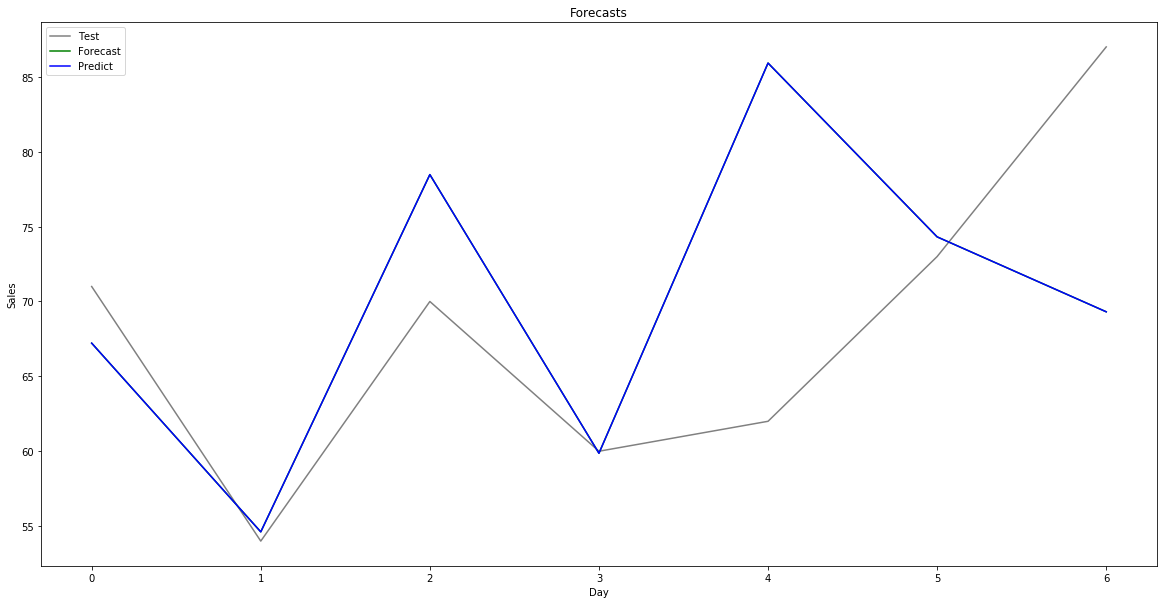

In [6]:
## Get data for store 4 and item 7:
store = 4
item = 7

train_4_7, dates_train, test_4_7, dates_test = get_sales(train, test, store, item)

## Remove seasonal component in data
differenced = difference(train_4_7, 365)

## Fit model with arbitray order
model = ARIMA(differenced, order=(7, 0, 1))
model_fit = model.fit(disp=0)

## Predictions
print("=============================\nOne step out-of-sample forecast\n")
### 1. One step out-of-sample forecasts
##### Forecast function
forecast = model_fit.forecast()[0]
forecast = inverse_difference(train_4_7, forecast, 365)

#### Predict function
start = len(differenced)
end = len(differenced)
prediction = model_fit.predict(start, end)
prediction = inverse_difference(train_4_7, prediction, 365)

print("True value: {}\nForecast function: {} | Predict function: {}".format(test_4_7[0], forecast, prediction))
print("=============================\nMultiple step out-of-sample forecast\n")

### 2. Multiple step out-of-sample forecast
#### Forecast function
days = 7

forecast = model_fit.forecast(steps=days)[0]

history = [x for x in train_4_7]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, 365)
    history.append(inverted)
    day +=1

#### Predict function
start = len(differenced)
end = start + days-1

prediction = model_fit.predict(start, end)

history_pred = [x for x in train_4_7]
day = 1
for yhat in prediction:
    inverted = inverse_difference(history_pred, yhat, 365)
    history_pred.append(inverted)
    day +=1

## Plots
plt.figure(figsize=[20,10])
plt.title("Forecasts")
plt.plot(test_4_7[:days], color='grey', label='Test')
plt.plot(history[-days:], color='green', label='Forecast')
plt.plot(history_pred[-days:], color='blue', label='Predict')
plt.xlabel("Day")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [7]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1369
Model:                     ARMA(7, 1)   Log Likelihood               -5540.838
Method:                       css-mle   S.D. of innovations             13.843
Date:                Sat, 22 Feb 2020   AIC                          11101.676
Time:                        11:40:28   BIC                          11153.894
Sample:                             0   HQIC                         11121.218
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5105      0.492      9.177      0.000       3.547       5.474
ar.L1.y       -0.1990      0.057     -3.517      0.000      -0.310      -0.088
ar.L2.y       -0.0172      0.026     -0.663      0.508      -0.068       0.034
ar.L3.y       -0.0430      0.025     -1.720      0.086      -0.092       0.006
ar.L4.y       -0.0158      0.025     -0.627      0.531      -0.065       0.034
ar.L5.y        0.0529      0.025      2.114      0.035       0.004       0.102
ar.L6.y       -0.0713      0.025     -2.829      0.005      -0.121      -0.022
ar.L7.y        0.4213      0.027     15.807      0.000       0.369       0.474
ma.L1.y        0.1481      0.063      2.356      0.019       0.025       0.271
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9620           -0.4622j            1.0673           -0.4287
AR.2           -0.9620           +0.4622j            1.0673            0.4287
AR.3           -0.2512           -1.1098j            1.1379           -0.2854
AR.4           -0.2512           +1.1098j            1.1379            0.2854
AR.5            1.1924           -0.0000j            1.1924           -0.0000
AR.6            0.7016           -0.9261j            1.1618           -0.1468
AR.7            0.7016           +0.9261j            1.1618            0.1468
MA.1           -6.7499           +0.0000j            6.7499            0.5000
-----------------------------------------------------------------------------
"""

#### 1.2 Parameter Optimization

We want to determine p, d, q to minimze the mean square error of our out-of-sample prediction. To get the best parameters we have to do a grid search [3].

In [5]:
def evaluate_arima_model(train, test, arima_order):
    '''
    Evaluate an ARIMA model of order (p, d, q).
    Returns the MSE.
    '''
    ## Remove seasonal components (year scale)    
    history = [x for x in train]   
    predictions = []
   
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)          
        yhat = model_fit.forecast()[0]         
        predictions.append(yhat)
        history.append(test[t])
        
    error = mean_squared_error(test, predictions)
    
    return error


def evaluate_models(train, test, p_values, d_values, q_values):
    '''
    Grid search on ARIMA models.
    Prints out the best parameter setting.
    '''
    train = np.array(train).astype('float32')
    test = np.array(test).astype('float32')
    
    best_score, best_config = float('inf'), None
    
    for p in p_values:      
        for d in d_values:            
            for q in q_values:
                order = (p,d,q)           
                
                try:
                    mse = evaluate_arima_model(train, test, order)
                    
                    if mse < best_score:
                        best_score, best_config = mse, order
                        
                    print('ARIMA order: {} | MSE: {:.4f}'.format(order, mse))                 
                
                except:
                    continue
    
    print("\n-----------------------------\nBest ARIMA order: {} | Best MSE: {}".format(best_config, mse))

In [ ]:
## Grid search for a store and an item
store = 4
item = 7

## Grid parameters
p_values = [6, 7, 8]
d_values = [1]
q_values = [0, 2, 3, 4]

## Get data for a store and an item
train_4_7, dates_train, test_4_7, dates_test = get_sales(train, test, store, item)

warnings.filterwarnings("ignore")
evaluate_models(train_4_7, test_4_7, p_values, d_values, q_values)

We know from running the grid search outside of this notebook that the best configuration is (8,1,3) (that is the smallest mean squared error in this case).

Let's use this configuration for forcasting now.

#### 1.3 Forecast with the best model

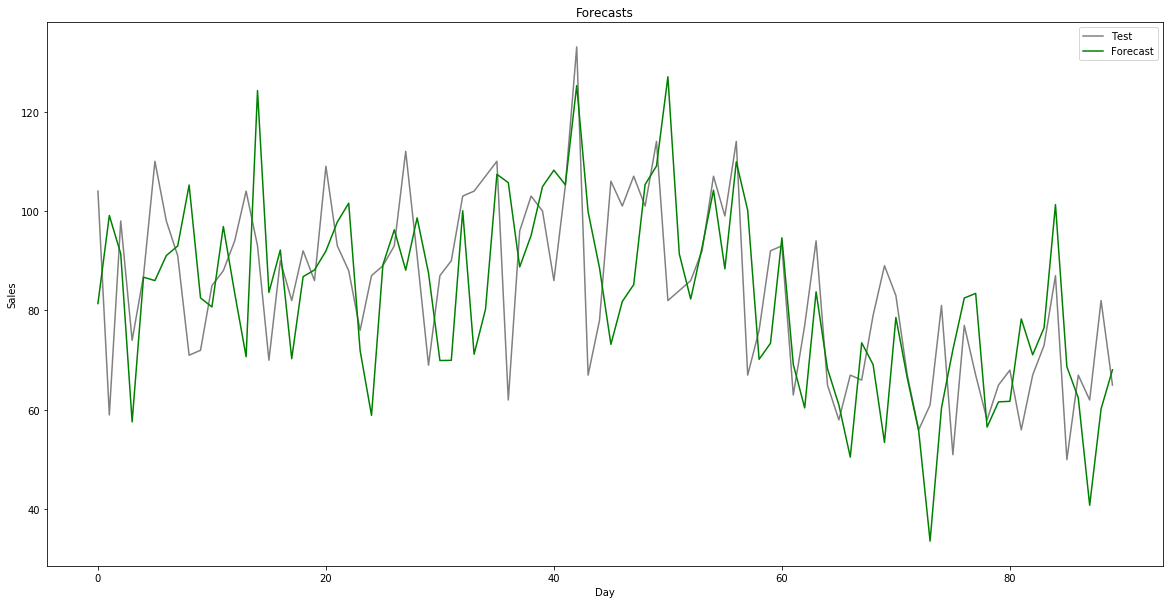

In [18]:
## Forecast with best model
train_4_7, dates_train, test_4_7, dates_test = get_sales(train, test, store, item)

def predict_arima(train_4_7, dates_train, test_4_7, dates_test):
    days = 90
    store = 1
    item = 15
    arima_order = (8,1,3)


    ## Get data for a store and an item:
    
    differenced = difference(train_4_7, 365)

    ## Fit model
    model = ARIMA(differenced, order=arima_order)
    model_fit = model.fit(disp=0)

    ## Predict
    forecast = model_fit.forecast(steps=days)[0]

    history = [x for x in train_4_7]
    day = 1
    for yhat in forecast:
        inverted = inverse_difference(history, yhat, 365)
        history.append(inverted)
        day +=1
    
    return history
 
arima_res = predict_arima(train_4_7, dates_train, test_4_7, dates_test)


## Plot
plt.figure(figsize=[20,10])
plt.title("Forecasts")
plt.plot(test_4_7[:days], color='grey', label='Test')
plt.plot(arima_res[-days:], color='green', label='Forecast')
plt.xlabel("Day")
plt.ylabel("Sales")
plt.legend()
plt.show()

/Users/David/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


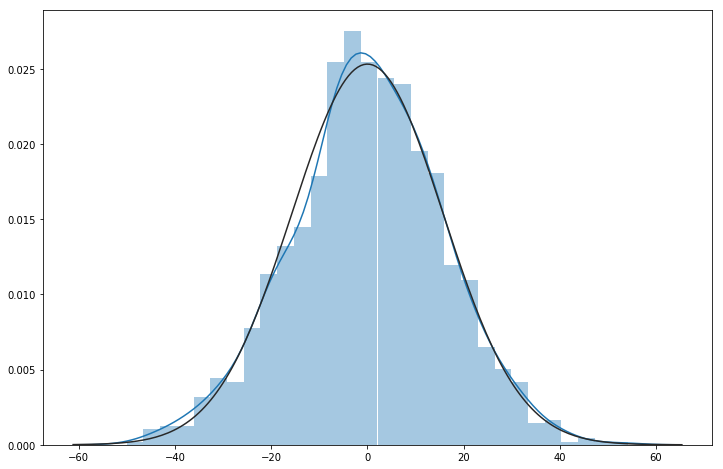

In [16]:
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(model_fit.resid ,fit = stats.norm, ax = ax0)
plt.show()

For a good model, the residual should be normally distributed. This is more or less the case here.

In [10]:
### All sales

def predict_all_arima(data):
    '''
    Predictions for all combinations of stores and items.
    Reads the dataframe for tests.
    Outputs the dataframe in plus the predicted sales.
    '''
  
    ## Initialize dataframe for output
    cols = ["date", "store", "item", "sales"]
    df_out = pd.DataFrame()
    
    ## Steps slice data
    stores = list(np.arange(1, 11))
    items = list(np.arange(1, 51))

    for store in stores:
        data_store = data.loc[data['store'] == store]
        
        for item in items:
            predictions = []
            clear_output(wait=True)
            print("Processing store {}/{} and item {}/{}".format(store, stores[-1], item, items[-1]))
            
            data_store_item = data_store.loc[data_store['item'] == item]
         
            train = data_store_item.loc[data_store_item['date'] < '2017-10-01' ]
            test = data_store_item.loc[data_store_item['date'] >= '2017-10-01' ]
            
            train_store_item, dates_train, test_store_item, dates_test = get_sales(train, test, store, item)
            
            
            ## Use model for prediction        
            # ARIMA parameters
            days = len(test_store_item)
            arima_order = (8,1,3)
            
            # Remove seasonal component
            differenced = difference(train_store_item, 365)

            # Fit model
            model = ARIMA(differenced, order=arima_order)
            model_fit = model.fit(disp=0)

            # Predict
            forecast = model_fit.forecast(steps=days)[0]

            history = [x for x in train_store_item]
            day = 1
            for yhat in forecast:
                inverted = inverse_difference(history, yhat, 365)
                #history.append(inverted)
                predictions.append(inverted)
                day +=1
                  
            ## Add prediction to output dataframe
            
            test["predicted ARIMA"] = predictions           
            df_out = df_out.append(test, ignore_index=True)
    
    ## Generate and save output 
    df_out.to_csv("Predictions_ARIMA.csv")
    print("Done!")

    return df_out

## Predict
data = pd.read_csv("./data/train.csv")
data['date'] = pd.to_datetime(data['date'])
df_arima = predict_all_arima(data)

Processing store 1/10 and item 16/50


/Users/David/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/David/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/David/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/David/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [ ]:
plot_sales_per_store_item(df_arima, 8, 4)

Unfortunately there is an error which can be traced back to the Intel MKL. We will later just use one store and item combination to compare ARIMA with SARIMA. So let's try SARIMA next.

### 2. Seasonal Autoregressive Integrated Moving-Average (SARIMA)

This extension of ARIMA allows handling of data with a seasonal component without removing the seasonality [4]. It adds the following four parameter:

P: Seasonal autoregressive order

D: Seasonal difference order

Q: Seasonal moving average order

m: The number of time steps for a single seasonal period

In the `statsmodels` library we can also provide a trend which we will gridsearch as well.

As for the ARIMA, the parameter have to be determined by gridsearch. We won't do that here due to time but the code is ready to run.

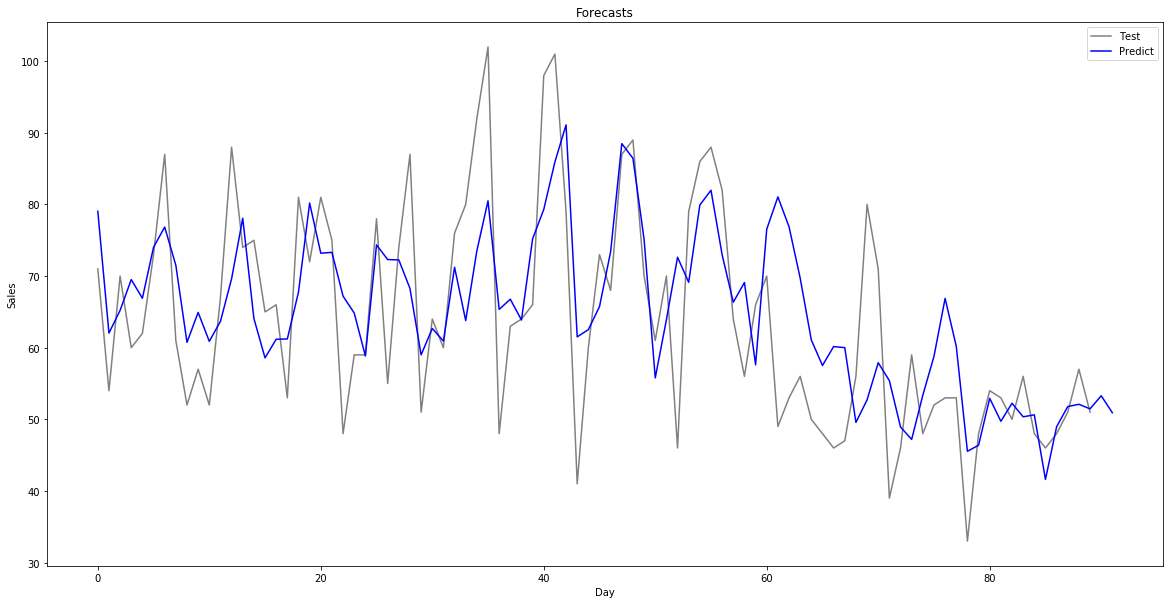

In [38]:
## Get data for store 4 and item 7:
train_4_7, dates_train, test_4_7, dates_test = get_sales(train, test, 4, 7)

def predict_sarima(train_4_7, dates_train, test_4_7, dates_test):
    days = 92
    
    ## Multiple step out-of-sample forecast with predict function

    test_4_7 = test_4_7[:days]

    start = len(train_4_7)
    end = start + days-1

    history = [x for x in train_4_7]
    predictions = []

    for i in range(len(test_4_7)):   
        # Fit model and make forecast for history
        model = SARIMAX(history, order=(6, 1, 0), seasonal_order=(0, 0, 0, 7), trend='n')
        model_fit = model.fit(disp=False)
        yhat = model_fit.predict(len(history), len(history))

        # Store forecast in list of predictions
        predictions.append(yhat)

        # Add actual observation to history for the next loop
        history.append(test_4_7[i])
        
    return predictions

sarima_res = predict_sarima(train_4_7, dates_train, test_4_7, dates_test)

## Plots
plt.figure(figsize=[20,10])
plt.title("Forecasts")
plt.plot(test_4_7[:days], color='grey', label='Test')
plt.plot(sarima_res, color='blue', label='Predict')
plt.xlabel("Day")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [25]:
def evaluate_sarima_model(train, test, arima_order, seasonal_order, trend):
    '''
    Evaluate an SARIMA model of order (p, d, q) (P, D, Q, m) with trends.
    Returns the MSE.
    '''
    ## Remove seasonal components (year scale)    
    history = [x for x in train]   
    predictions = []
   
    for t in range(len(test)):
        model = SARIMAX(history, order=arima_order, seasonal_order=seasonal_order, trend=trend)
        model_fit = model.fit(disp=0)               
        yhat = model_fit.predict(len(history), len(history))        
        predictions.append(yhat)
        history.append(test[t])
        
    error = mean_squared_error(test, predictions)
    
    return error


def evaluate_all_sarima_models(train, test, p_values, d_values, q_values, P_values, D_values, Q_values, m_values):
    '''
    Grid search on SARIMA models.
    Inputs:
    train, test: lists of sales for a given store and an item
    grid parameters as lists
    Prints out the best parameter setting.
    '''
    
    train = np.array(train).astype('float32')
    test = np.array(test).astype('float32')
    
    best_score, best_config, best_seasonal, best_trend = float('inf'), None, None, None
    
    for p in p_values:      
        for d in d_values:            
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for m in m_values:
                                    arima_order = (p,d,q)
                                    seasonal_order = (P,D,Q,m)
                                    trend = "c"
                                    try: 
                                        print("Fitting model ARIMA order {} seasonal order {} trend {}".format(arima_order, seasonal_order, trend))
                                        mse = evaluate_sarima_model(train, test, arima_order, seasonal_order, trend)
                                        print(mse)
                                        if mse < best_score:
                                            best_score, best_config, best_seasonal, best_trend = mse, arima_order, seasonal_order, trend

                                        print('SARIMA order: {} | Seasonal order: {} | Trend: {} | MSE: {:.4f}'.format(order, seasonal_order, trend, mse))                               
                                    except:
                                        continue
    
    print("\n-----------------------------\nBest SARIMA order: {} | Best seasonal order: {} | Best Trend: {} | Best MSE: {}".format(best_score, best_config, best_seasonal, best_trend))

In [ ]:
#### Grid search
p_values = [1, 8, 9]
d_values = [1]
q_values = [3, 7]

P_values = [1]
D_values = [1]
Q_values = [0]
m_values = [7]
#trends = ['n', 'c']

store = 4
item = 7


## Get data for a store and an item
train_4_7, dates_train, test_4_7, dates_test = get_sales(train, test, store, item)


#evaluate_sarima_model(train_4_7, test_4_7, (1,0,1), (1,1,2,7), 'c')

warnings.filterwarnings("ignore")
evaluate_all_sarima_models(train_4_7, test_4_7, p_values, d_values, q_values, P_values, D_values, Q_values, m_values)

In [ ]:
#### Prediction with best model

def predict_all_sarima(data):
    '''
    Predictions for all combinations of stores and items.
    Reads the dataframe for tests.
    Outputs the dataframe in plus the predicted sales.
    '''
  
    ## Initialize dataframe for output
    cols = ["date", "store", "item", "sales"]
    df_out = pd.DataFrame()
    
    ## Steps slice data
    stores = list(np.arange(1, 11))
    items = list(np.arange(1, 51))

    for store in stores:
        data_store = data.loc[data['store'] == store]
        
        for item in items:
            predictions = []
            clear_output(wait=True)
            print("Processing store {}/{} and item {}/{}".format(store, stores[-1], item, items[-1]))
            
            data_store_item = data_store.loc[data_store['item'] == item]
         
            train = data_store_item.loc[data_store_item['date'] < '2017-10-01' ]
            test = data_store_item.loc[data_store_item['date'] >= '2017-10-01' ]
            
            train_store_item, dates_train, test_store_item, dates_test = get_sales(train, test, store, item)
            
            
            ## Use model for prediction
            
            # SARIMA parameters
            days = len(test_store_item)
            arima_order = (6,1,0)
            seasonal_order = (0,0,0,7)
        

            # Fit model
            start = 1
            end = 1
            
            predict = model_fit.predict(start, end)

            history = [x for x in train_store_item]
            day = 1
            for yhat in forecast:
                inverted = inverse_difference(history, yhat, 365)
                #history.append(inverted)
                predictions.append(inverted)
                day +=1
                  
            ## Add prediction to output dataframe
            
            test["predicted SARIMA"] = predictions           
            df_out = df_out.append(test, ignore_index=True)
    
    ## Generate and save output 
    df_out.to_csv("Predictions_SARIMA.csv")
    print("Done!")

    return df_out

## Predict
data = pd.read_csv("./data/train.csv")
data['date'] = pd.to_datetime(data['date'])
df_sarima = predict_all_sarima(data)

In [ ]:
#### Plot
plot_sales_per_store_item(df_sarima, 8, 4)

SARIMA for all stores has not been computed here since it takes a long time to fit each model.

## ARIMA vs. SARIMA vs. Truth

We now compare the predictions of ARIMA and SARIMA for one store and item combination.

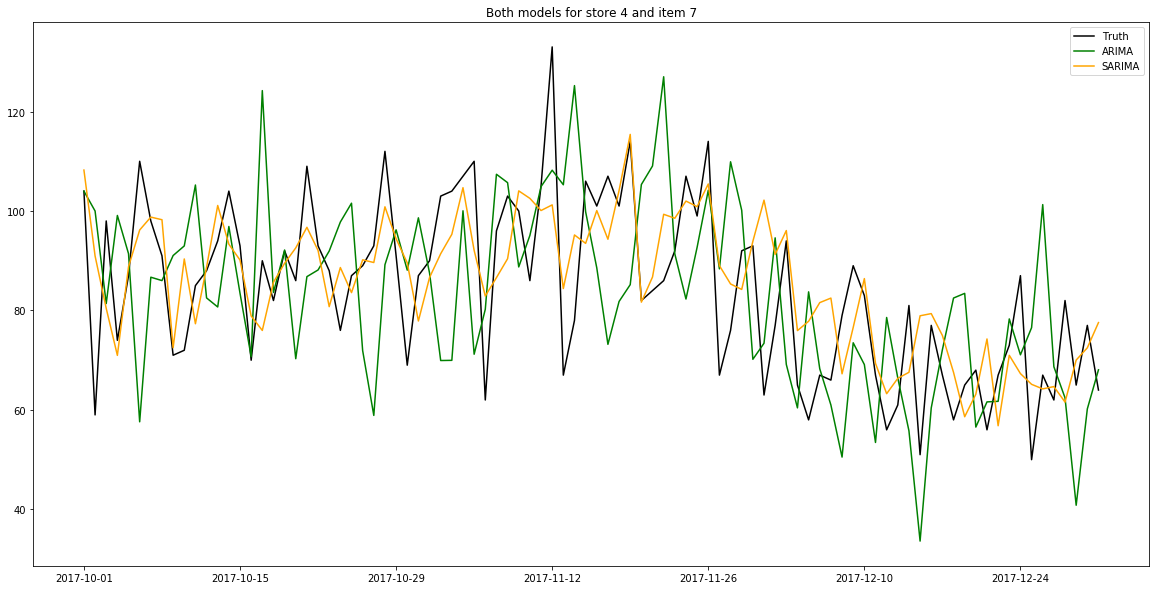

In [39]:
## Compare ARIMA and SARIMA
train_4_7, dates_train, test_4_7, dates_test = get_sales(train, test, store, item)

arima_res = predict_arima(train_4_7, dates_train, test_4_7, dates_test)
sarima_res = predict_sarima(train_4_7, dates_train, test_4_7, dates_test)

def plot_results(test, arima_res, sarima_res, dates_test):
       
    plt.figure(figsize=[20,10])
    plt.title("Both models for store 4 and item 7")
    plt.plot(dates_test, test[:92], color="black", label="Truth")
    plt.plot(dates_test, arima_res[-92:], color="green", label="ARIMA")
    plt.plot(dates_test, sarima_res, color="orange", label="SARIMA")
    plt.xticks(np.arange(0, len(test), 14))
    plt.legend()
    
plot_results(test_4_7, arima_res, sarima_res, dates_test)

## Conclusion

The data has both seasonality on more than one scale as well as a trend. The two models tried here seem to capture the trend for item 7 from store 4 well. However, the individual peaks are missed fairly often. A metric like the MSE could be used to quantify the quality of both models.

Better results could probably be achieved with proper hyperparameter tuning.

However, we will move on to machine learning models which are able to perform much better on this task.

# References


[1] Cryer, Chan. *Time Series Analysis*. 2008

[2] Brownlee. [How to Create an ARIMA Model for Time Series Forecasting in Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/). Accessed on 19/02/2020

[3] Brownlee. [How to Grid Search ARIMA Model Hyperparameters with Python](https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/). Accessed on 19/02/2020

[4] Brownlee. [A Gentle Introduction to SARIMA for Time Series Forecasting in Python](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/). Accessed on 19/02/2020


[5] Brownlee. [11 Classical Time Series Forecasting Methods in Python](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/). Accessed on 15/02/2020 